In [1]:
# When performing classification one often wants to predict not only the class label, but also the associated probability. 
# This probability gives some kind of confidence on the prediction. 
# This example demonstrates how to display how well calibrated the predicted probabilities are.

# "Well-calibrated" classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly
# interpreted as a confidence level. For instance a well calibrated (binary) classifier should classify the samples such that
# among the samples to which it gave a predict_proba value close to 0.8, approx. 80% actually belong to the positive
# class.

%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

# Build a data set
try: 
    # make_classification generates a random n-class classification problem.
    # make_classification specialises in introducing noise by way of: correlated, redundant and uninformative features; multiple Gaussian clusters per class; and linear transformations of the feature space.
    X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=2)
    # The experiment is performed on an artificial dataset for binary classification with 100.000 samples (1.000 of them are
    # used for model fitting) with 20 features. Of the 20 features, only 2 are informative and 10 are redundant. 
except: # make_classification might not work with older version of sklearn
    digits = datasets.load_digits()
    X, y = digits.data, digits.target
    #X = StandardScaler().fit_transform(X)
    # classify small against large digits
    y = (y > 4).astype(np.int)


train_samples = 100  # Samples used for training the models

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

In [2]:
## Create classifiers

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

classifiers = {'Logistic':LogisticRegression(),
               'Naive Bayes':GaussianNB(),
               'Support Vector Classification':LinearSVC(C=1.0),
               'Random Forest':RandomForestClassifier(n_estimators=100),
               'Naive Bayes Calibrated with isotonic calibration':CalibratedClassifierCV( GaussianNB(), cv=2, method='isotonic'),
               'Naive Bayes Calibrated with sigmoid calibration':CalibratedClassifierCV( GaussianNB(), cv=2, method='sigmoid'),
               'Support Vector Classification Calibrated with isotonic calibration':CalibratedClassifierCV( LinearSVC(C=1.0), cv=2, method='isotonic'),
               'Support Vector Classification Calibrated with sigmoid calibration':CalibratedClassifierCV( LinearSVC(C=1.0), cv=2, method='sigmoid'),
               }


Support Vector Classification Calibrated with isotonic calibration:
	Brier: 0.113
	Precision: 0.789
	Recall: 0.906
	F1: 0.843

Support Vector Classification:
	Brier: 0.172
	Precision: 0.839
	Recall: 0.838
	F1: 0.839

Naive Bayes Calibrated with isotonic calibration:
	Brier: 0.125
	Precision: 0.783
	Recall: 0.899
	F1: 0.837

Logistic:
	Brier: 0.113
	Precision: 0.839
	Recall: 0.853
	F1: 0.846

Support Vector Classification Calibrated with sigmoid calibration:
	Brier: 0.115
	Precision: 0.813
	Recall: 0.897
	F1: 0.853

Naive Bayes Calibrated with sigmoid calibration:
	Brier: 0.127
	Precision: 0.785
	Recall: 0.898
	F1: 0.838

Naive Bayes:
	Brier: 0.128
	Precision: 0.793
	Recall: 0.891
	F1: 0.839

Random Forest:
	Brier: 0.113
	Precision: 0.849
	Recall: 0.915
	F1: 0.881



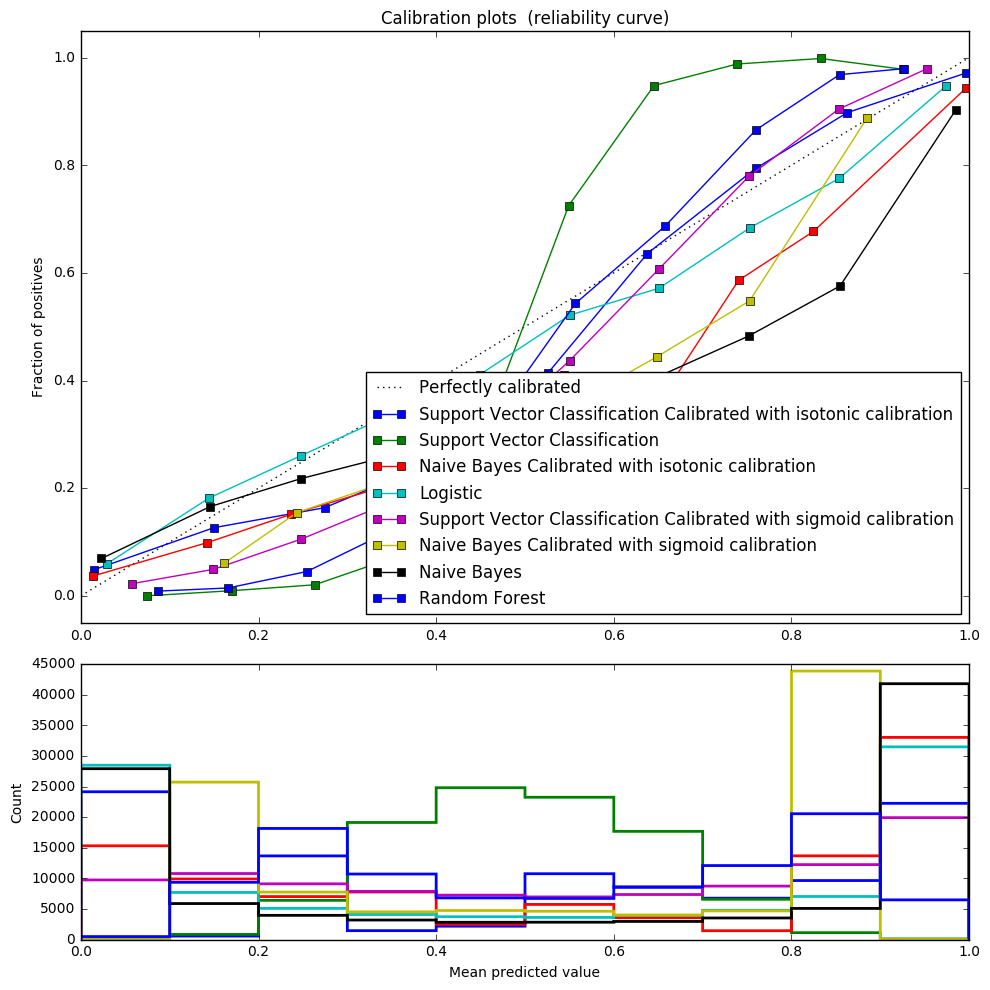

In [6]:
## Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for name, clf in classifiers.items():                  
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test) # generate predictions
    if hasattr(clf, "predict_proba"): # some classifier generate probability estimates as predictions and others just 'scores'
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
            
    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
    print("%s:" % name)
    # The calibration performance is evaluated with Brier score, reported in the legend (the smaller the better). 
    '''
    In partiuclar, across all items in a set N predictions, the Brier score measures the mean squared difference between (1) 
    the predicted probability assigned to the possible outcomes for item i, and (2) the actual outcome. Therefore, the
    lower the Brier score is for a set of predictions, the better the predictions are calibrated. Note that the Brier score
    always takes on a value between zero and one, since this is the largest possible difference between a predicted
    probability (which must be between zero and one) and the actual outcome (which can take on values of only 0
    and 1).
    The Brier score is appropriate for binary and categorical outcomes that can be structured as true or false, but
    is inappropriate for ordinal variables which can take on three or more values (this is because the Brier score
    assumes that all possible outcomes are equivalently “distant” from one another). Which label is considered to
    be the positive label is controlled via the parameter pos_label, which defaults to 1.
    '''
    # Wikipedia entry for Brier score: http://en.wikipedia.org/wiki/Brier_score
    
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))
        
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10) # Compute true and predicted probabilities for a calibration curve

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')
#ax1.legend_.remove() # uncomment this line to remove the legend

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
ax2.legend_.remove()

plt.tight_layout()
plt.show()

In [4]:
#  The first figure shows the estimated probabilities obtained with the different classification methods.

# LogisticRegression returns well calibrated predictions as it directly optimizes log-loss. 
# In contrast, the other methods return biased probilities, with different biases per method.

# GaussianNaiveBayes tends to push probabilties to 0 or 1 (note the counts in the histograms). This is mainly because it makes the assumption that features are conditionally independent given the class, which is not the case in this dataset which contains 2 redundant features.

# Calibration of the probabilities of Gaussian naive Bayes with isotonic regression can fix this issue as can be seen from the nearly diagonal calibration curve. 
# Sigmoid calibration also improves the brier score slightly, albeit not as strongly as the non-parametric isotonic regression. 
# This can be attributed to the fact that we have plenty of calibration data such that the greater flexibility of the non-parametric model can be exploited.

# LinearSVC shows the opposite behavior as Gaussian naive Bayes: the calibration curve has a sigmoid curve, which is typical for an under-confident classifier. 
# In the case of LinearSVC, this is caused by the margin property of the hinge loss, which lets the model focus on hard samples that are close to the decision boundary (the support vectors).

# Both kinds of calibration can fix this issue and yield nearly identical results. 
# This shows that sigmoid calibration can deal with situations where the calibration curve of the base classifier is sigmoid (e.g., for LinearSVC) but not where it is transposed-sigmoid (e.g., Gaussian naive Bayes).